# Modeling and Model Visulizations
> In this notebook, the images from directory will be put through and image dataset generator and modeled using CNN. The various models will change and tune layers to achieve the highest accuracy score with the lowest loss in the validation set. These models will then be visualized using some graphing functions below to see how well the model performs. The best model will be saved and will e utilized in the following noteook: Gradm_Cam to visualize heatmaps over the images in the dataset. 

---

## Imports
> Please note that this noteook was run in google colab, so be aware before you try running this yourself. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import itertools

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomBrightness, RandomContrast, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam

from sklearn.metrics import confusion_matrix

from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

## Visualization Functions
> The following locks of code will be instantiating variables that will be later utilized in the functions that follow it. Please adjust these variables as you need for your own personal directory. 

>The functions listed below will make graphs based on the models run to visualize model growth, predictions, accuracy, and loss. These will be used to monitor progress. 

In [ ]:
image_directory = '/content/drive/MyDrive/Capstone/images/brain_scans'
visuals_directory = '/content/drive/MyDrive/Capstone/images/visuals/'
modeling_directory = '/content/drive/MyDrive/Capstone/data/'
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

In [ ]:
def plot_history(hist, name):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='#fc746c', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='#8e8efd', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], c='#fc746c', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='#8e8efd', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")

    plt.savefig(visuals_directory + name + '.jpg')
    plt.show()

In [ ]:
def get_true_labels(datagen):
    """Returns the true labels for a batch dataset created with image_dataset_from_directory.
    
    Parameters:
        datagen (keras.utils.Sequence): A batch dataset created with image_dataset_from_directory
    
    Returns:
        np.array: An array of true labels with shape (num_samples,)
    """
    label_map = dict(zip(datagen.class_names, range(len(datagen.class_names))))
    labels = []
    for batch in datagen:
        batch_labels = batch[1].numpy()
        batch_labels = np.argmax(batch_labels, axis=1)
        labels.extend(batch_labels)
    labels = np.array(labels)
    return labels

In [ ]:
def plot_confusion_matrix(model, val_gen, name, title):
  model_labels = [i.title() for i in val_gen.class_names]
  preds = np.argmax(model.predict(val_gen), axis = 1)
  true_val = get_true_labels(val_gen)
  pred_df = pd.DataFrame(confusion_matrix(true_val, preds), index=model_labels,columns=model_labels)

  plt.figure(figsize=(12,10))
  sns.heatmap(pred_df, annot=True, fmt='g')
  plt.xlabel('Actual')
  plt.ylabel('Prediction')
  plt.title(title)
  plt.savefig(visuals_directory + name + '.jpg')
  plt.show();  

In [ ]:
def wrong_predictions(model, val_gen, num):
  preds = np.argmax(model.predict(val_gen), axis = 1)
  true_val = get_true_labels(val_gen)
  results = pd.DataFrame(preds, columns=['Predicted'])
  results['Actual'] = true_val
  results['fp'] = val_gen.file_paths

  row_ids = results[results['Predicted'] != results['Actual']].index

  for value in itertools.islice(row_ids, num):
    plt.imshow(Image.open(results['fp'].iloc[value]))
    plt.show()
    print(f'The model guessed this was: {class_names[results["Predicted"].iloc[value]]}.')
    print(f'This actually is: {class_names[results["Actual"].iloc[value]]}.')
    print()


---

## Preprocessing
> The following blocks of code sets up the image generator, which pulls images from the brain scan directory and labels them according to their folder location. It then splits the images into two different datasets based on the validation split for training and testing. 

In [ ]:
train_gen, val_gen = image_dataset_from_directory(
    image_directory,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.2,
    subset="both",
    image_size =(512,512),
    seed=2023,
)

Found 7023 files belonging to 4 classes.
Using 5619 files for training.
Using 1404 files for validation.


## Modeling 
> The following code blocks are modeling the dataset generated by the previous block of code. I'll be using functional CNN models and tuning the layers to maximize accuracy and minimize loss. 

### Check Points

In [ ]:
checkpoint = ModelCheckpoint(modeling_directory + 'best_weights.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience = 7, restore_best_weights=True, start_from_epoch=15)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

## Model A

In [ ]:
inputs = keras.Input(shape=(512, 512, 1))
x = Rescaling(1/255)(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

history = model.fit(
    train_gen,
    validation_data=val_gen, 
    epochs=100,
    callbacks=[early_stop, checkpoint]
)

print(model.evaluate(val_gen))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 512, 512, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 255, 255, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                             

In [ ]:
model.save(modeling_directory + 'modelA')

## Model A Visualizations

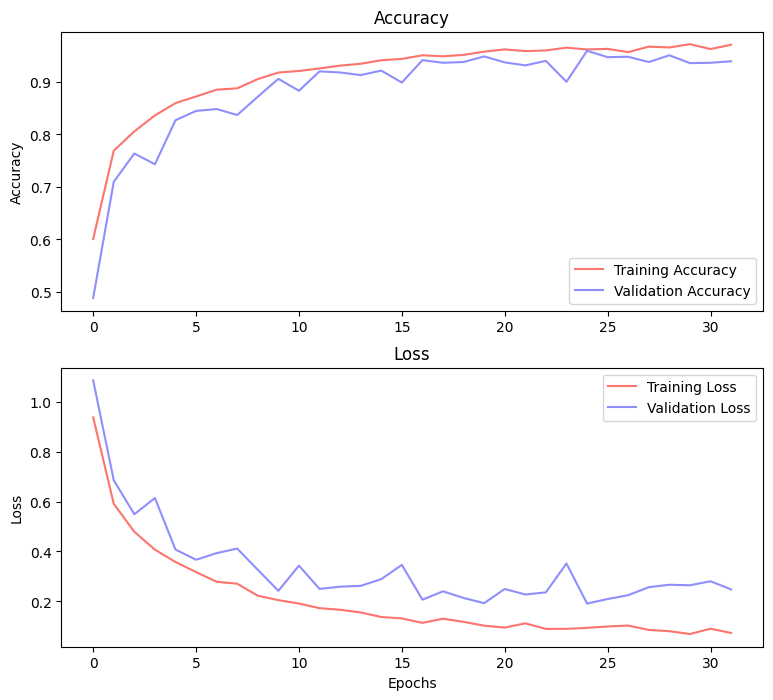

In [ ]:
plot_history(history, 'modelA_history')

44/44 [==============================] - 2s 52ms/step


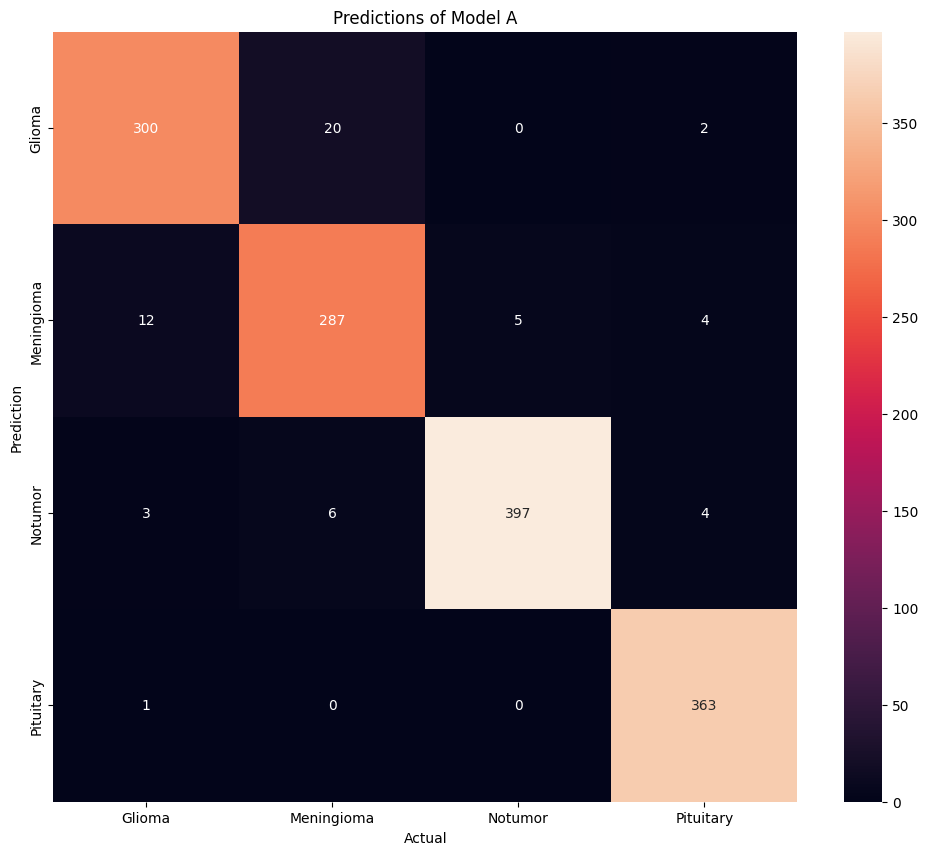

In [ ]:
plot_confusion_matrix(model, val_gen, 'modelA_cm', 'Predictions of Model A')

44/44 [==============================] - 3s 61ms/step


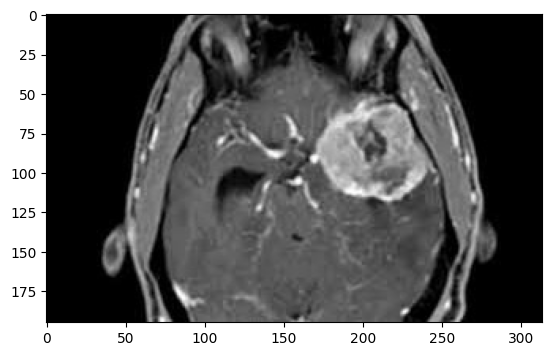

The model guessed this was: No Tumor.
This actually is: Meningioma.



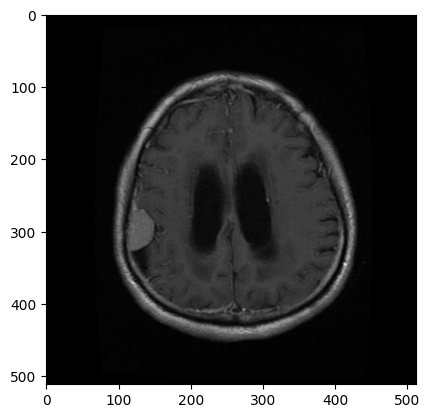

The model guessed this was: Glioma.
This actually is: Meningioma.



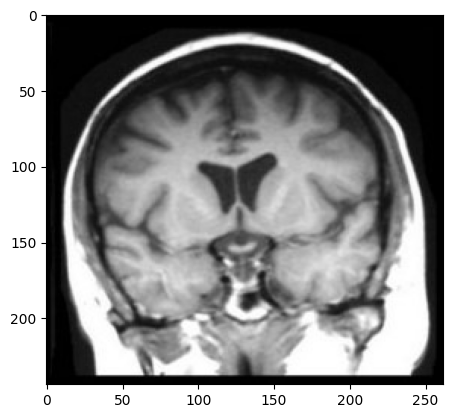

The model guessed this was: Meningioma.
This actually is: No Tumor.



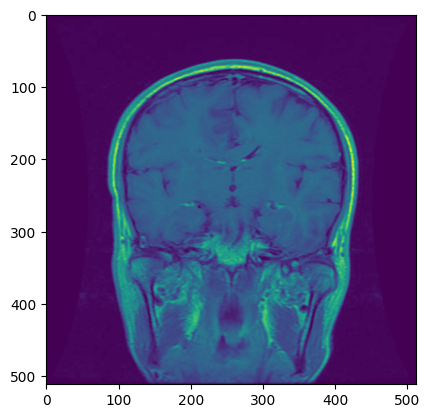

The model guessed this was: Meningioma.
This actually is: Glioma.



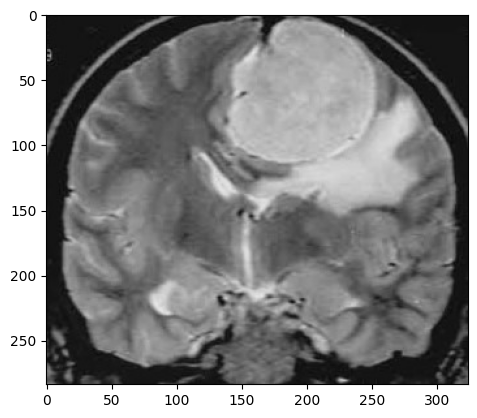

The model guessed this was: No Tumor.
This actually is: Meningioma.



In [ ]:
wrong_predictions(model, val_gen, 5)

----

## Model B

In [ ]:
inputs = keras.Input(shape=(512, 512, 1))
x = Rescaling(1/255)(inputs)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='sigmoid')(x)

modelb = keras.Model(inputs=inputs, outputs=outputs)

print(modelb.summary())

modelb.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc', keras.metrics.AUC()]
)

historyb = modelb.fit(
    train_gen,
    validation_data=val_gen, 
    epochs=200,
    callbacks=[early_stop, checkpoint]
)

print(modelb.evaluate(val_gen))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 512, 512, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 255, 255, 32)     0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 255, 255, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 253, 253, 64)      18496     
                                                           

In [ ]:
modelb.save(modeling_directory + 'modelB')

## Model B Visualizations

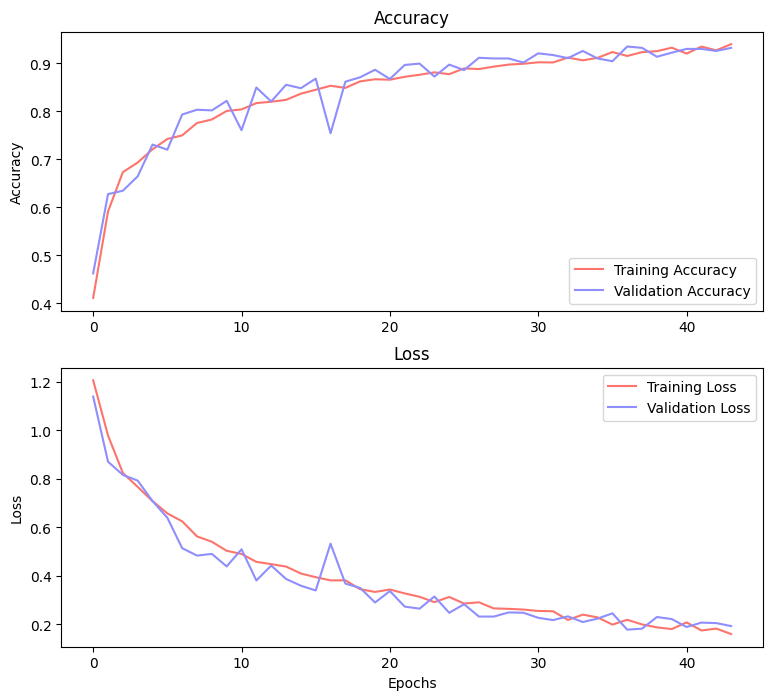

In [ ]:
plot_history(historyb, 'modelB_history')

44/44 [==============================] - 4s 85ms/step


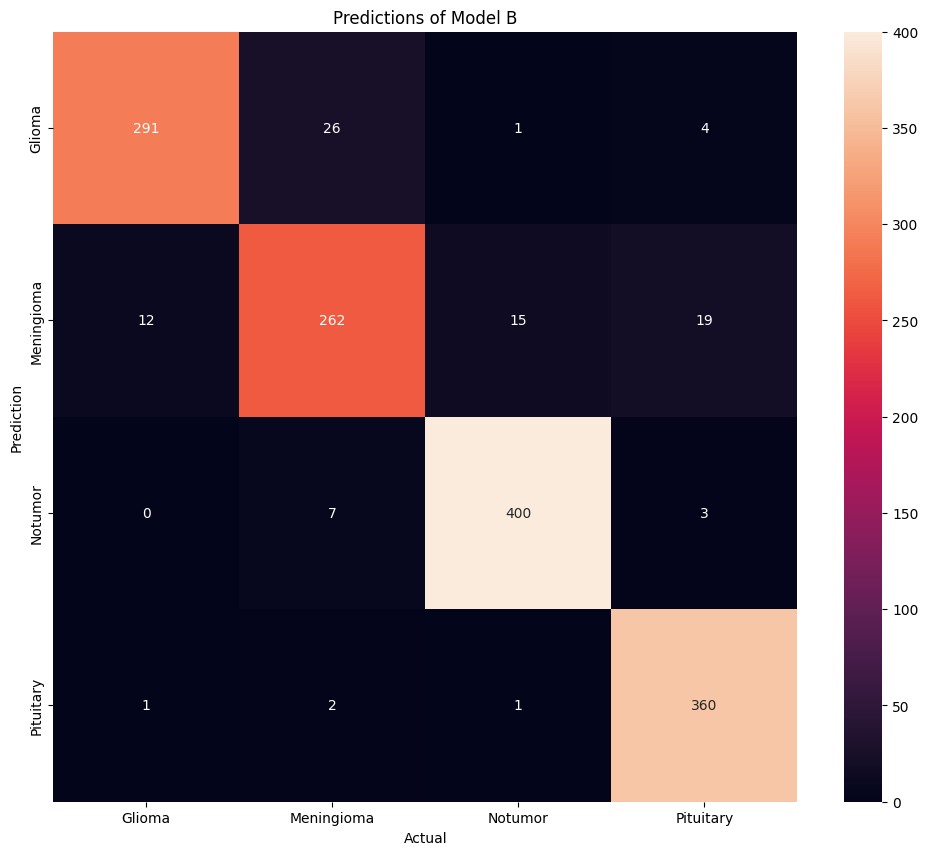

In [ ]:
plot_confusion_matrix(modelb, val_gen, 'modelB_cm', 'Predictions of Model B')

44/44 [==============================] - 4s 86ms/step


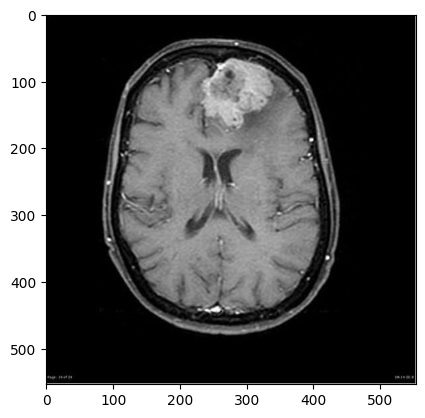

The model guessed this was: No Tumor.
This actually is: Meningioma.



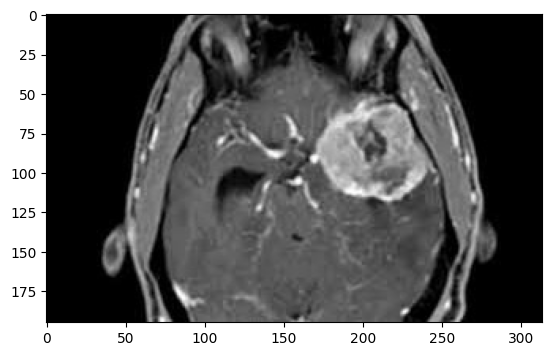

The model guessed this was: Pituitary.
This actually is: Meningioma.



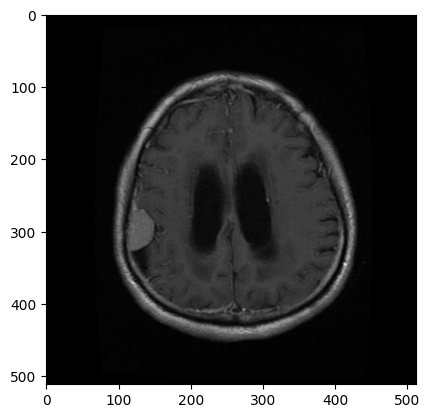

The model guessed this was: Glioma.
This actually is: Meningioma.



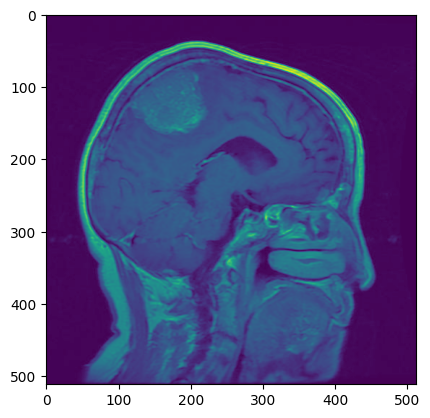

The model guessed this was: Glioma.
This actually is: Meningioma.



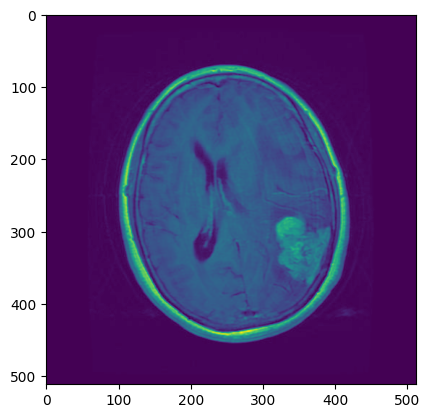

The model guessed this was: Glioma.
This actually is: Meningioma.



In [ ]:
wrong_predictions(modelb, val_gen, 5)

---

## Model C

In [ ]:
inputs = keras.Input(shape=(512, 512, 1))
x = Rescaling(1/255)(inputs)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='sigmoid')(x)

modelc = keras.Model(inputs=inputs, outputs=outputs)

print(modelc.summary())

modelc.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc', keras.metrics.AUC()]
)

historyc = modelc.fit(
    train_gen,
    validation_data=val_gen, 
    epochs=200,
    callbacks=[early_stop, checkpoint]
)

print(modelc.evaluate(val_gen))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 512, 512, 1)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 510, 510, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 510, 510, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 255, 255, 32)     0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 255, 255, 32)      0   

In [ ]:
modelc.save(modeling_directory + 'modelC')

## Model C Visualization

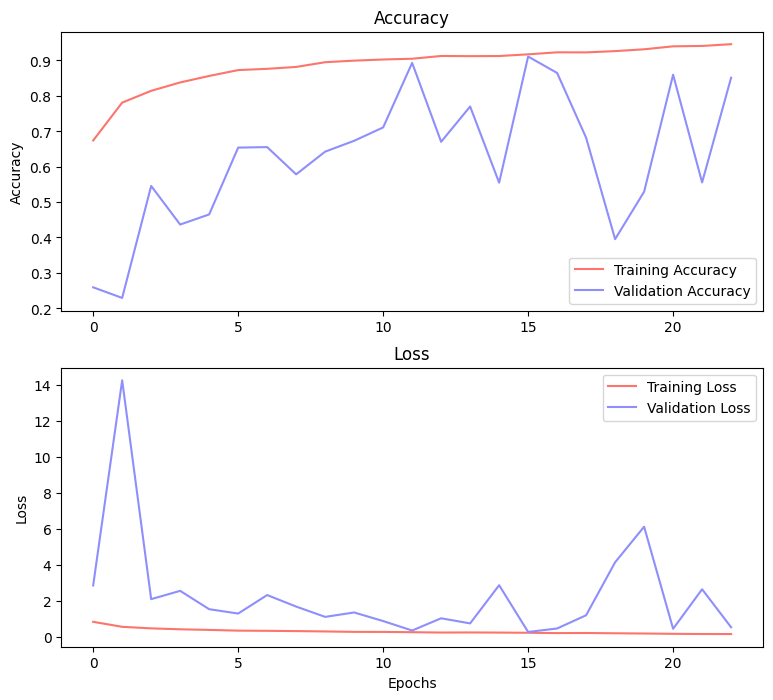

In [ ]:
plot_history(historyc, 'modelC_history')

44/44 [==============================] - 4s 84ms/step


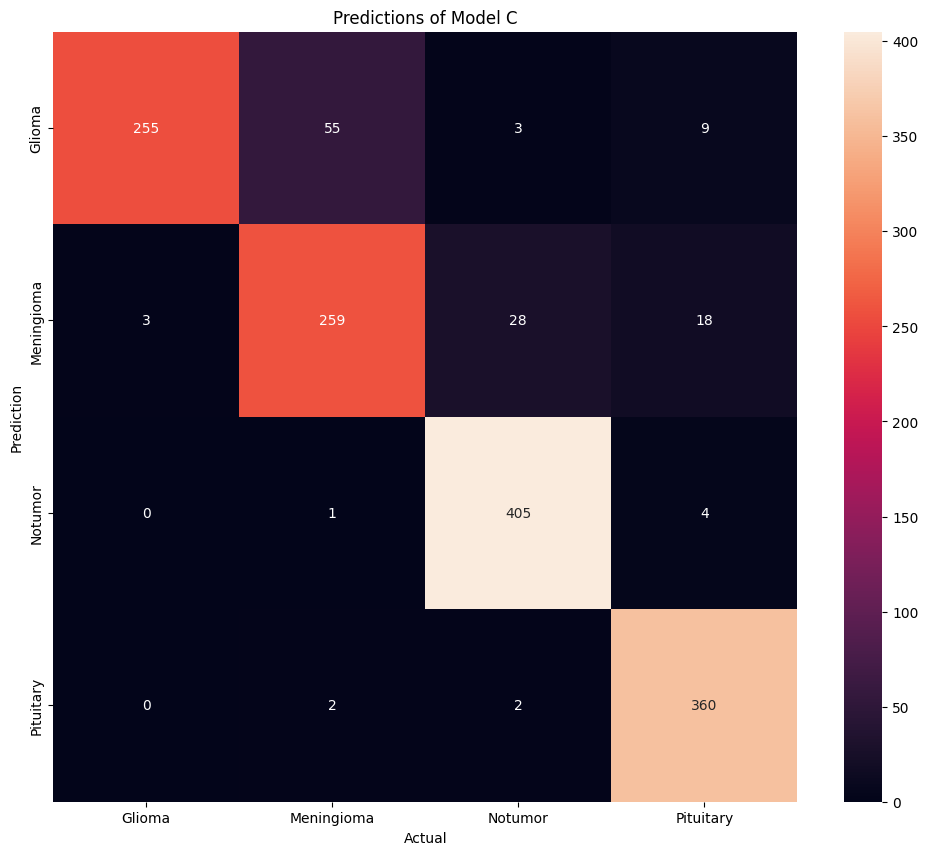

In [ ]:
plot_confusion_matrix(modelc, val_gen, 'modelC_cm', 'Predictions of Model C')

44/44 [==============================] - 4s 89ms/step


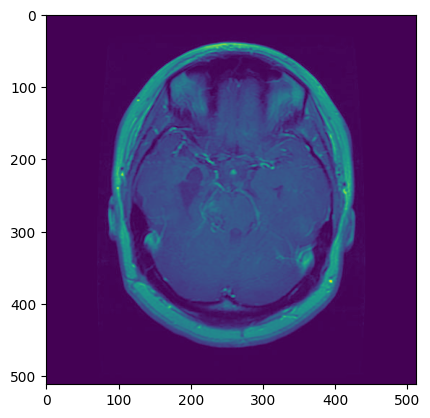

The model guessed this was: Pituitary.
This actually is: Glioma.



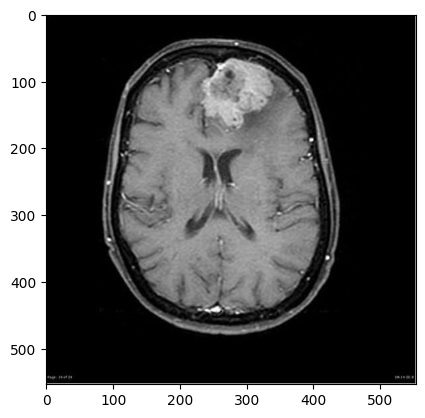

The model guessed this was: No Tumor.
This actually is: Meningioma.



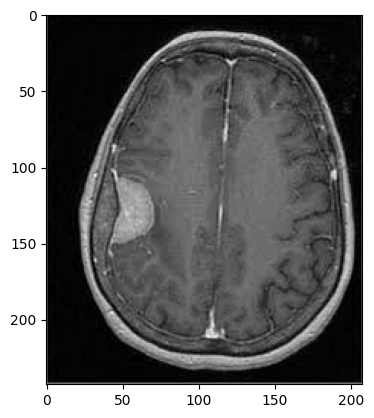

The model guessed this was: Pituitary.
This actually is: Meningioma.



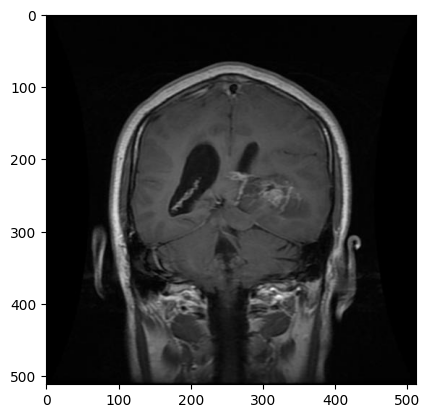

The model guessed this was: Meningioma.
This actually is: Glioma.



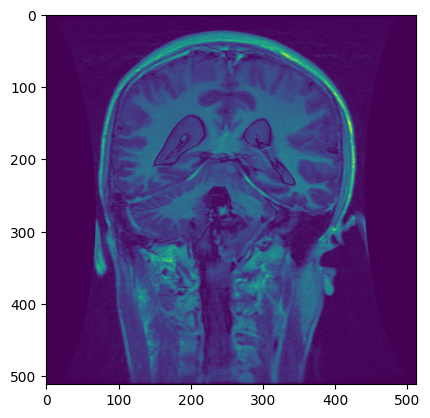

The model guessed this was: Meningioma.
This actually is: Glioma.



In [ ]:
wrong_predictions(modelc, val_gen, 5)

---

In [ ]:
#Base model2, picked up from a previous lesson
model2 = Sequential()
model2.add(Rescaling(1/255, input_shape=(512,512,1)))
model2.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(512,512,1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation='softmax'))

print(model2.summary())

model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

history2 = model2.fit(
    train_gen,
    validation_data= val_gen, 
    epochs=100,
    callbacks = [early_stop, reduce_lr]
)

print(model2.evaluate(val_gen))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 512, 512, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 510, 510, 16)      160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 255, 255, 16)     0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 255, 255, 16)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 126, 126, 32)     0         
 g2D)                                                   

KeyboardInterrupt: ignored

In [ ]:
#Base model3, picked up from a previous lesson
model3 = Sequential()
model3.add(Rescaling(1/255, input_shape=(512,512,1)))
model3.add(RandomFlip("horizontal_and_vertical"))
model3.add(RandomRotation(0.2))
model3.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(512,512,1)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4, activation='softmax'))

print(model3.summary())

model3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

history3 = model3.fit(
    train_gen,
    validation_data= val_gen, 
    epochs=100,
    callbacks = [early_stop, reduce_lr]
)

print(model3.evaluate(val_gen))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 512, 512, 1)       0         
                                                                 
 random_flip (RandomFlip)    (None, 512, 512, 1)       0         
                                                                 
 random_rotation (RandomRota  (None, 512, 512, 1)      0         
 tion)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 510, 510, 16)      160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 255, 255, 16)     0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 255, 255, 16)     

In [ ]:
#Base model4, picked up from a previous lesson
model4 = Sequential()
model4.add(Rescaling(1/255, input_shape=(512,512,1)))
model4.add(RandomContrast(factor=.5, seed=2023))
model4.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(512,512,1)))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(4, activation='softmax'))

print(model4.summary())

model4.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

history4 = model4.fit(
    train_gen,
    validation_data= val_gen, 
    epochs=100,
    callbacks = [early_stop, reduce_lr]
)

print(model4.evaluate(val_gen))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 512, 512, 1)       0         
                                                                 
 random_contrast_2 (RandomCo  (None, 512, 512, 1)      0         
 ntrast)                                                         
                                                                 
 conv2d_30 (Conv2D)          (None, 510, 510, 16)      160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 255, 255, 16)     0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 255, 255, 16)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 253, 253, 32)    

In [ ]:
#Base model5, picked up from a previous lesson
model5 = Sequential()
model5.add(Rescaling(1/255, input_shape=(512,512,1)))
model5.add(RandomContrast(factor=.8, seed=2023))
model5.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(512,512,1)))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))
model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))
model5.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))
model5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))
model5.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(4, activation='softmax'))

print(model5.summary())

model5.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

history5 = model5.fit(
    train_gen,
    validation_data= val_gen, 
    epochs=100,
    callbacks = [early_stop, reduce_lr]
)

print(model5.evaluate(val_gen))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 512, 512, 1)       0         
                                                                 
 random_contrast_3 (RandomCo  (None, 512, 512, 1)      0         
 ntrast)                                                         
                                                                 
 conv2d_35 (Conv2D)          (None, 510, 510, 16)      160       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 255, 255, 16)     0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 255, 255, 16)      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 253, 253, 32)    